# Toxic Comment Visualization

In [48]:
# load required libraries:
# Remember to pip install spacy and scattertext 
# If errors still exist, open your terminal and type python -m spacy download en

import joblib
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')

import numpy as np
import pandas as pd
import sklearn

import vocabulary
import tokenizer
import vector
import dataclean
import lemmatizer
import pos_tagger

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scattertext as st
from IPython.display import IFrame

In [49]:
# load the comment data
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


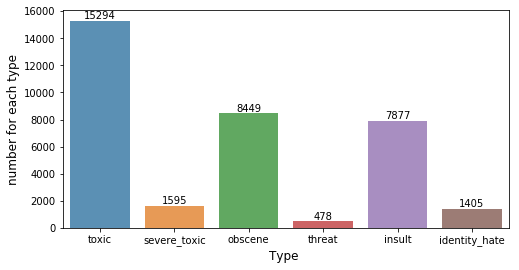

In [15]:
x=train.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.ylabel('number for each type', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

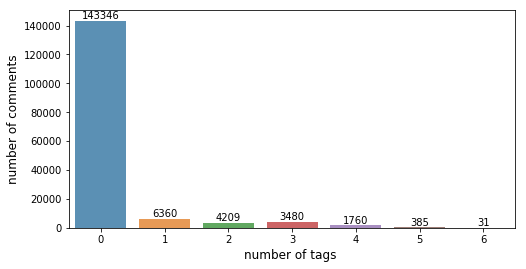

In [16]:
rowsums=train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.ylabel('number of comments', fontsize=12)
plt.xlabel('number of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [17]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [18]:
train.comment_text[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [50]:
# shuffle and take the first 10k rows for the ease of preprocessing
train = train.sample(frac=1).reset_index(drop=True)
train = train[:10000]

In [51]:
# remove punctuation
cleaner = dataclean.DataClean()
train.comment_text = train.comment_text.apply(cleaner.clean)

In [52]:
# NLTK stoplist with 3136 words
STOPLIST = set(nltk.corpus.stopwords.words())
tkn = tokenizer.Tokenizer()


def remove_stopwords(text):
    # remove stop words from text
    tokens = tkn.tokenize(text)
    words = [word for word in tokens if word not in STOPLIST]
    return " ".join(words)


# remove stopwords from comments
train.comment_text = train.comment_text.apply(remove_stopwords)

In [53]:
# parse the comments
train.comment_text = train.comment_text.apply(nlp)

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,f297eb61033cfb05,"(references, really, canonical, ?, reference, ...",0,0,0,0,0,0
1,5688e3c95d4b6c88,"(exactly, ., clear, guidelines, place, self, p...",0,0,0,0,0,0
2,2b800bc2c4d5eb5e,"(question, stats, minor, quibble, ., article, ...",0,0,0,0,0,0
3,219ac63222da4ada,"(links, sites, erroneous, claims, although, an...",0,0,0,0,0,0
4,034380b8a8d44868,"(commonwealth, instead, dominion, ?, based, up...",0,0,0,0,0,0


In [54]:
def create_corpus(dataframe,label):
    """
    a function that convert dataframe into scattertext corpus
    :param dataframe: dataframe to be converted
    :param label: type of toxicity behavior
    :return: a corpus that is required as an input of scattertext plot
    """
    dataframe[label] = dataframe[label].replace(0, 'Not '+label)
    dataframe[label] = dataframe[label].replace(1, label)
    corpus = st.CorpusFromParsedDocuments(dataframe,
                                          category_col=label,
                                          parsed_col='comment_text').build()
    return corpus


def visualize_chart(corpus, toxicity, not_toxicity):
    """
    a function that visualize the text using the scattertext library
    :param corpus: data to be visualized
    :param toxicity: type of toxicity behavior
    :not_toxicity:
    :output: a scattertext plot
    """
    html = st.produce_scattertext_explorer(corpus,
                                        category=toxicity,
                                        category_name=toxicity,
                                        not_category_name=not_toxicity,
                                        width_in_pixels=1000,
                                        minimum_term_frequency=5,
                                        transform=st.Scalers.log_scale_standardize)
    filename='visualization/'+toxicity+'_vs_'+not_toxicity+'.html'
    with open(filename, 'wb') as f:
        f.write(html.encode('utf-8'))
        IFrame(src=filename, width = 1200, height=700)

# plot the characteristic terms used by different comment group
toxicity_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for toxicity in toxicity_list:
    corpus = create_corpus(train, toxicity)
    visualize_chart(corpus, toxicity, "Not "+toxicity)
